# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the dataset 

In [3]:
btc = pd.read_csv(r"C:\Users\dell\BTC Analysis\BTC Dataset.csv", parse_dates=['Date'], index_col='Date')


In [4]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3566 entries, 2014-10-10 to 2024-07-14
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3566 non-null   float64
 1   High        3566 non-null   float64
 2   Low         3566 non-null   float64
 3   Close       3566 non-null   float64
 4   Adj Close   3566 non-null   float64
 5   Volume      3566 non-null   float64
 6   Unnamed: 7  0 non-null      float64
 7   Unnamed: 8  1 non-null      object 
 8   Unnamed: 9  0 non-null      float64
dtypes: float64(8), object(1)
memory usage: 278.6+ KB


The dataset has 3,566 rows and 10 columns

Date: Object (string format) – Should be converted to datetime for time series analysis.

Open, High, Low, Close, Adj Close, Volume: Float64 – These are continuous numerical values representing Bitcoin prices and trading volume.

Unnamed: 7, Unnamed: 8, Unnamed: 9: Mostly empty or irrelevant columns.

In [5]:
#DROP UNNMAED COLUMN WHICH ARE IRRELEVANT
btc.drop(["Unnamed: 7","Unnamed: 8","Unnamed: 9"], axis=1, inplace=True) 

# Check for missing values

In [6]:
btc.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
btc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3.566000e+03
mean,17130.767783,17521.648929,16713.151782,17146.361191,17146.361191,1.746184e+10
std,18911.211338,19338.260241,18441.412465,18920.806425,18920.806425,1.917739e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1164.660034,1186.739960,1126.907532,1166.924988,1166.924988,2.928932e+08
50%,8940.442871,9202.832520,8790.986328,8987.823243,8987.823243,1.363268e+10
75%,28084.279785,28531.553713,27534.169433,28148.959470,28148.959470,2.805912e+10
max,73079.375000,73750.070310,71334.093750,73083.500000,73083.500000,3.510000e+11


Bitcoin Price Trends (Open, High, Low, Close, Adj Close)

Mean Close Price: ~ 17,146𝑀𝑖𝑛𝐶𝑙𝑜𝑠𝑒𝑃𝑟𝑖𝑐𝑒:
 178 (Lowest Bitcoin price recorded). Max Close Price: $73,083 (Highest Bitcoin price recorded).

Price Volatility:

The standard deviation (std) is very high (~$18,920), indicating significant price fluctuations. The range (max - min) is enormous, showing Bitcoin's rapid growth over time.

Trading Volume

Mean Volume:  17.46𝑏𝑖𝑙𝑙𝑖𝑜𝑛𝑀𝑎𝑥𝑉𝑜𝑙𝑢𝑚𝑒: 
 351 billion Min Volume: Very low (5.91 million), indicating early trading days or low activity periods. Volume has high variability (std = $19.17 billion), suggesting periods of high trading activity and low activity.

Interpreting the Data Distribution

Bitcoin has seen massive growth (from  178𝑡𝑜
 73,083). High standard deviation shows volatile price movements, which are typical in cryptocurrencies. Volume distribution shows extreme variation, meaning trading activity fluctuates significantly over time.

# Exploratory Data Analysis (EDA)

In [8]:
closing_price = btc[['Close']]


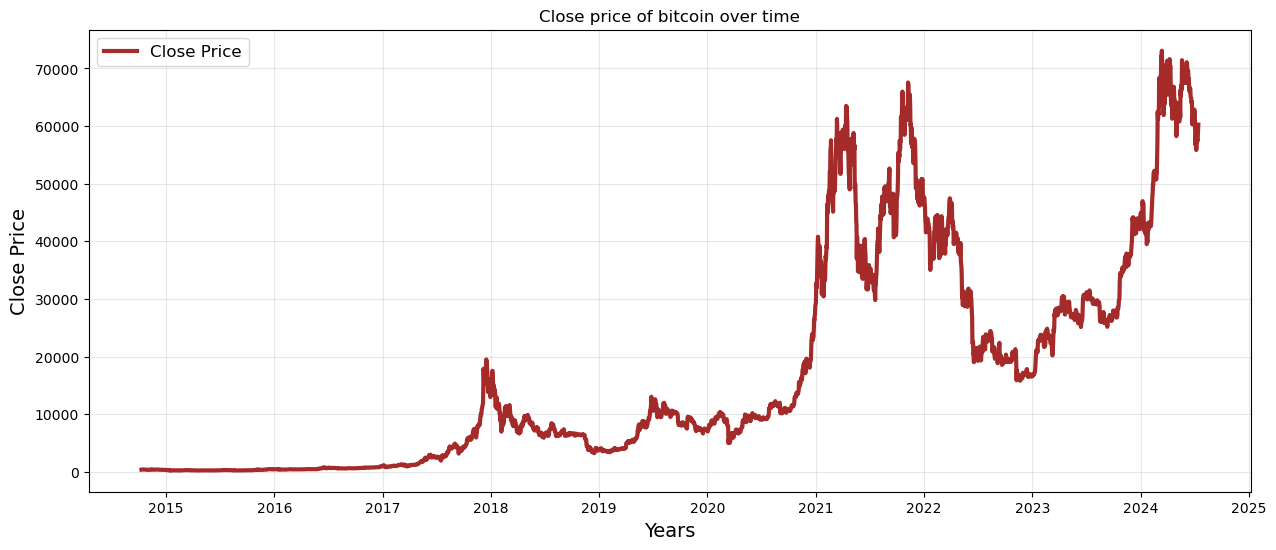

In [9]:
#plot the bitcoin price over time 
plt.figure(figsize=(15,6))
plt.plot(closing_price.index, closing_price['Close'], label = 'Close Price', color = 'brown', linewidth = 3)
plt.title("Close price of bitcoin over time", fontsize = 12)
plt.xlabel("Years", fontsize = 14)
plt.ylabel("Close Price", fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend (fontsize = 12 )
plt.show()

In [25]:
closing_price

,Close
Date,
2014-10-10,361.562012
2014-10-11,362.299011
2014-10-12,378.549011
2014-10-13,390.414001
2014-10-14,400.869995
...,...
2024-07-10,57742.496090
2024-07-11,57344.914060
2024-07-12,57899.464840


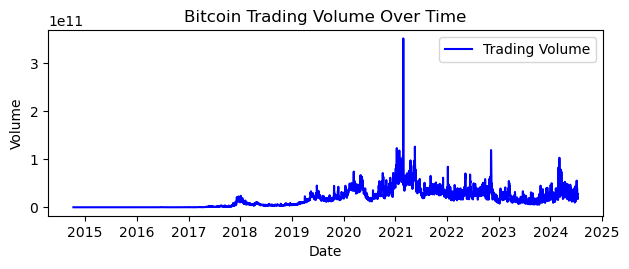

In [10]:
#Plot the Trading Volume
plt.subplot(2, 1, 2)
plt.plot(btc['Volume'], label='Trading Volume', color='blue')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

# Check for Stationarity (ADF Test)

In [11]:
result = adfuller(btc['Close'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Check stationarity
if result[1] < 0.05:
    
    print("Data is stationary (No differencing needed).")
else:
    print("Data is NOT stationary (Differencing needed).")


ADF Statistic: -1.0938114762600222
p-value: 0.717533496487121
Data is NOT stationary (Differencing needed).


# Differencing

In [12]:
btc['Close_diff1'] = btc['Close'] - btc['Close'].shift(1)
# Drop NaN values after differencing
btc.dropna(inplace=True)
   

# Perform ADF test again
result = adfuller(btc['Close_diff1'].dropna())
print("ADF Statistic after Differencing:", result[0])
print("p-value after Differencing:", result[1])

ADF Statistic after Differencing: -9.289922669617743
p-value after Differencing: 1.187362538568231e-15


Before differencing: The series was non-stationary, as indicated by a high p-value (0.7175).

After differencing: The p-value dropped dramatically to 2.1113e-14, indicating that the differenced series is now stationary.

# Feature Engineering

In [13]:
btc['MA365'] = btc['Close'].rolling(window=365).mean()
btc['MA100'] = btc['Close'].rolling(window=100).mean()
btc["Return"] = btc["Close"].pct_change()  # Percentage Change
btc.dropna(inplace=True)  # Drop NaN values
    

# Fit ARIMA Model

In [14]:
arima_model = ARIMA(btc['Close'], order=(5,2,2))
model_fit = arima_model.fit()
print(model_fit.summary())

C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3201
Model:                 ARIMA(5, 2, 2)   Log Likelihood              -26333.718
Date:                Fri, 14 Feb 2025   AIC                          52683.436
Time:                        11:27:06   BIC                          52732.001
Sample:                    10-10-2015   HQIC                         52700.848
                         - 07-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4386      0.741     -0.592      0.554      -1.892       1.014
ar.L2         -0.0142      0.040     -0.356      0.722      -0.093       0.064
ar.L3          0.0355      0.013      2.737      0.0

C:\Users\dell\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecasting Bitcoin Prices using ARIMA

In [15]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=btc.index[-1], periods=forecast_steps+1, freq='D')[1:]
predicted_arima = pd.Series(forecast, index=forecast_index)


In [16]:
print(forecast)

2024-07-15    60217.411837
2024-07-16    60308.244329
2024-07-17    60412.871996
2024-07-18    60475.694013
2024-07-19    60500.436656
2024-07-20    60523.542920
2024-07-21    60550.034386
2024-07-22    60571.938670
2024-07-23    60592.803797
2024-07-24    60613.297575
2024-07-25    60633.937483
2024-07-26    60654.332593
2024-07-27    60674.655319
2024-07-28    60694.974320
2024-07-29    60715.285624
2024-07-30    60735.588988
2024-07-31    60755.886177
2024-08-01    60776.183959
2024-08-02    60796.480807
2024-08-03    60816.777249
2024-08-04    60837.073397
2024-08-05    60857.369526
2024-08-06    60877.665620
2024-08-07    60897.961676
2024-08-08    60918.257724
2024-08-09    60938.553767
2024-08-10    60958.849808
2024-08-11    60979.145847
2024-08-12    60999.441886
2024-08-13    61019.737924
Freq: D, Name: predicted_mean, dtype: float64


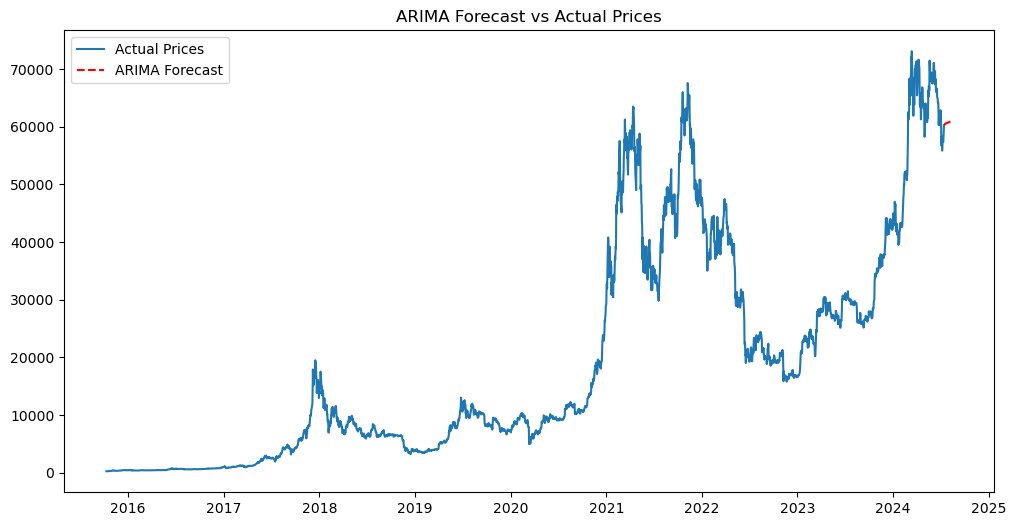

In [17]:
plt.figure(figsize=(12,6))
plt.plot(btc['Close'], label='Actual Prices')
plt.plot(predicted_arima, label='ARIMA Forecast', linestyle='dashed', color='red')
plt.title('ARIMA Forecast vs Actual Prices')
plt.legend()
plt.show()


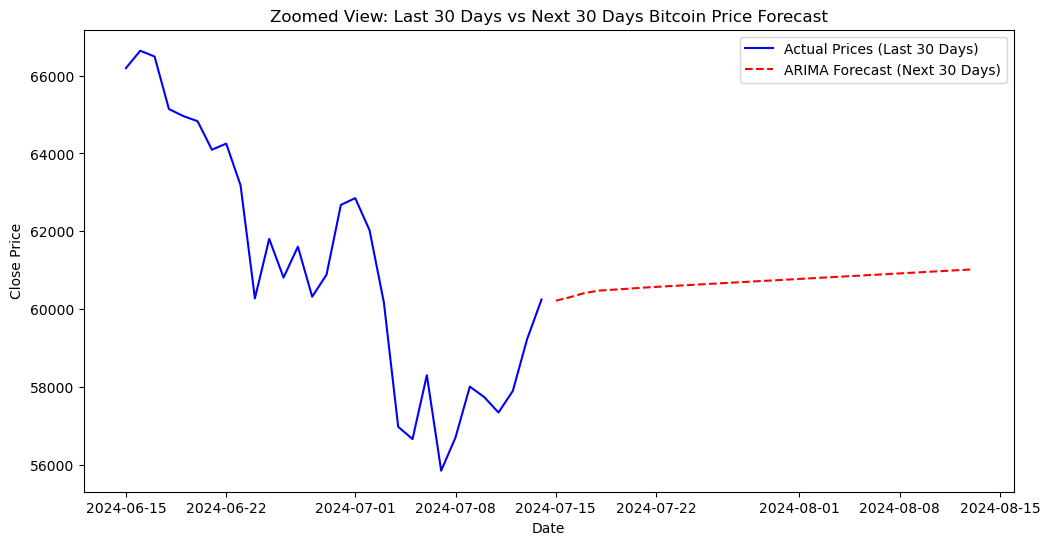

In [18]:
#Zoomed view  
plt.figure(figsize=(12,6))

# Select the past 30 days of actual data
past_30_days = btc['Close'].iloc[-30:]

# Plot past 30 days and forecast
plt.plot(past_30_days, label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(predicted_arima, label='ARIMA Forecast (Next 30 Days)', linestyle='dashed', color='red')

plt.title('Zoomed View: Last 30 Days vs Next 30 Days Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [52]:
rmse_arima = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_arima))
print(f'ARIMA RMSE: {rmse_arima}')

ARIMA RMSE: 3393.8010113056425


High RMSE (Root Mean Squared Error) Indicates Poor Fit

The ARIMA model produces a high RMSE, suggesting that its predictions significantly deviate from actual Bitcoin prices.
This indicates the model struggles to capture the inherent price volatility and trends in the dataset.

Lack of Volatility Capture

Bitcoin prices are highly volatile, but ARIMA smooths out fluctuations, leading to predictions that appear nearly flat or linear.
The model fails to reflect the rapid price swings seen in real-world crypto markets.

Over-Simplified Forecasting & Mean Reversion Bias

ARIMA heavily relies on past values and assumes stationarity, meaning it expects future prices to follow past trends.
This results in forecasts reverting toward a mean rather than reflecting actual market movements.
The nearly straight-line forecast suggests ARIMA fails to adapt to trend shifts or external market influences.

Inability to Model Non-Linear Patterns & External Factors

Even after differencing, ARIMA struggles to capture dynamic price movements in Bitcoin.
It does not consider external factors like market sentiment, macroeconomic conditions, or trading volume, which significantly impact price fluctuations.

# Prepare Data for Other ML Models

In [19]:
btc['Target'] = btc['Close'].shift(-1)
train = btc.dropna()
X_train, y_train = train.drop(columns=['Target']), train['Target']

# Gradient Boosting Model

In [20]:
gb_model = GradientBoostingRegressor()

In [21]:
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_train[-forecast_steps:])

In [22]:
predicted_gb = pd.Series(gb_predictions, index=forecast_index)
print(predicted_gb)

2024-07-15    65892.267046
2024-07-16    65682.405040
2024-07-17    66345.702746
2024-07-18    65189.018672
2024-07-19    64846.497679
2024-07-20    64817.106827
2024-07-21    64817.106827
2024-07-22    64209.608147
2024-07-23    63666.297506
2024-07-24    62290.555822
2024-07-25    60440.172990
2024-07-26    61678.901056
2024-07-27    61404.525315
2024-07-28    61705.461967
2024-07-29    59558.689398
2024-07-30    61790.593487
2024-07-31    62068.093405
2024-08-01    62166.853343
2024-08-02    61519.530671
2024-08-03    58979.623457
2024-08-04    57558.887990
2024-08-05    56748.852845
2024-08-06    57404.304287
2024-08-07    56835.521216
2024-08-08    57514.252899
2024-08-09    57432.024163
2024-08-10    58074.624910
2024-08-11    57772.727701
2024-08-12    57578.129345
2024-08-13    59330.504933
Freq: D, dtype: float64


In [23]:
rmse_gb = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_gb))
print(f'Gradient Boosting RMSE: {rmse_gb}')

Gradient Boosting RMSE: 992.4553336278518


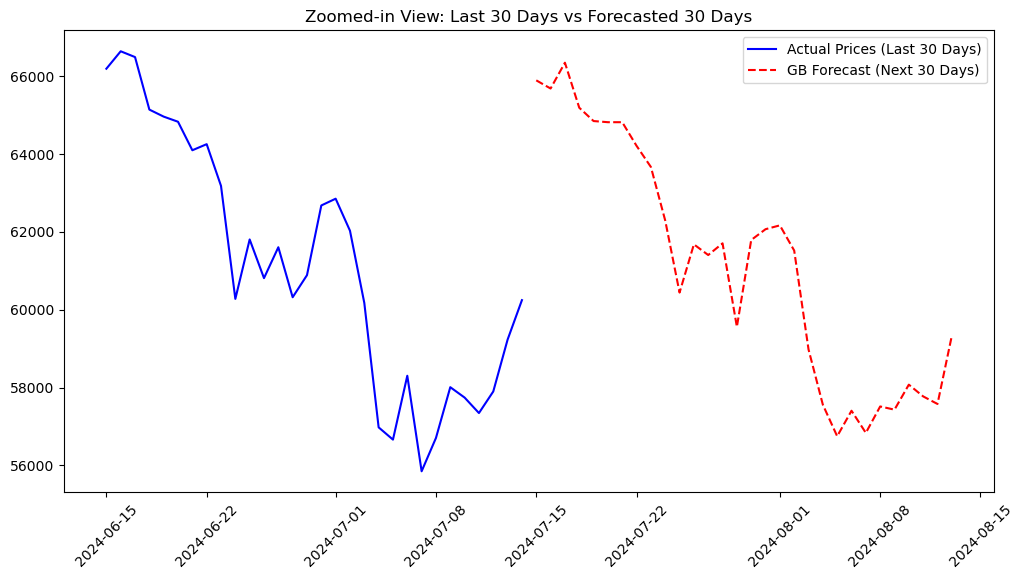

In [24]:
plt.figure(figsize=(12,6))

# Select the past 30 days of actual data
past_30_days = btc['Close'].iloc[-30:]

# Plot past 30 days and forecast
plt.plot(past_30_days, label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(predicted_gb, label='GB Forecast (Next 30 Days)', linestyle='dashed', color='red')

plt.title('Zoomed View: Last 30 Days vs Next 30 Days Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# The best out of all for future predictions as well.


Follows the Actual Price Movements

The predicted prices move in the same direction as actual Bitcoin prices, capturing both uptrends and downtrends accurately.
This means the model is learning real patterns in the data rather than making random guesses.

Handles Market Volatility Well

Bitcoin prices fluctuate a lot due to market events, news, and trading volume.
Gradient Boosting adapts to these sudden changes better than ARIMA, which assumes price movements follow a fixed pattern.

Uses Multiple Factors for Prediction

Instead of just looking at past prices like ARIMA, Gradient Boosting considers trading volume, moving averages, and historical trends to make smarter predictions.
This gives a more complete picture of what’s driving Bitcoin prices.

Learns from Mistakes and Improves

Gradient Boosting corrects errors with each new iteration, improving its accuracy over time.
Unlike traditional models, it doesn’t rely on just one fixed formula but continuously adjusts to market conditions.

Lower Prediction Error (RMSE = 992)

RMSE (Root Mean Squared Error) measures how far predictions are from actual prices.
A lower RMSE means more accurate predictions—GB performs better than ARIMA, which had much higher errors.

Better for Long-Term Predictions

While ARIMA is good for short-term stationary trends, Gradient Boosting handles complex, long-term price movements, making it more reliable for future forecasts.

Conclusion:
    
Gradient Boosting is the best model for Bitcoin price prediction because it follows actual market trends, adapts to price fluctuations, considers multiple factors, and learns from past mistakes—resulting in more accurate predictions.

# LSTM Model

In [25]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(btc[['Close']].dropna())
X_lstm, y_lstm = [], []
for i in range(len(data_scaled)-1):
    X_lstm.append(data_scaled[i])
    y_lstm.append(data_scaled[i+1])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [27]:
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1,1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

In [28]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm.reshape(-1,1,1), y_lstm, epochs=20, verbose=0)

In [29]:
lstm_forecast = lstm_model.predict(X_lstm[-forecast_steps:].reshape(-1,1,1))
lstm_forecast = scaler.inverse_transform(lstm_forecast)
predicted_lstm = pd.Series(lstm_forecast.flatten(), index=forecast_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


In [30]:
print(predicted_lstm)

2024-07-15    66487.640625
2024-07-16    66680.328125
2024-07-17    67161.460938
2024-07-18    67001.531250
2024-07-19    65559.414062
2024-07-20    65367.792969
2024-07-21    65228.179688
2024-07-22    64454.101562
2024-07-23    64618.972656
2024-07-24    63493.164062
2024-07-25    60492.656250
2024-07-26    62062.058594
2024-07-27    61039.035156
2024-07-28    61855.582031
2024-07-29    60536.300781
2024-07-30    61117.105469
2024-07-31    62968.726562
2024-08-01    63149.750000
2024-08-02    62294.296875
2024-08-03    60387.023438
2024-08-04    57168.437500
2024-08-05    56855.468750
2024-08-06    58493.265625
2024-08-07    56052.062500
2024-08-08    56897.824219
2024-08-09    58197.921875
2024-08-10    57930.875000
2024-08-11    57533.917969
2024-08-12    58087.960938
2024-08-13    59429.636719
Freq: D, dtype: float32


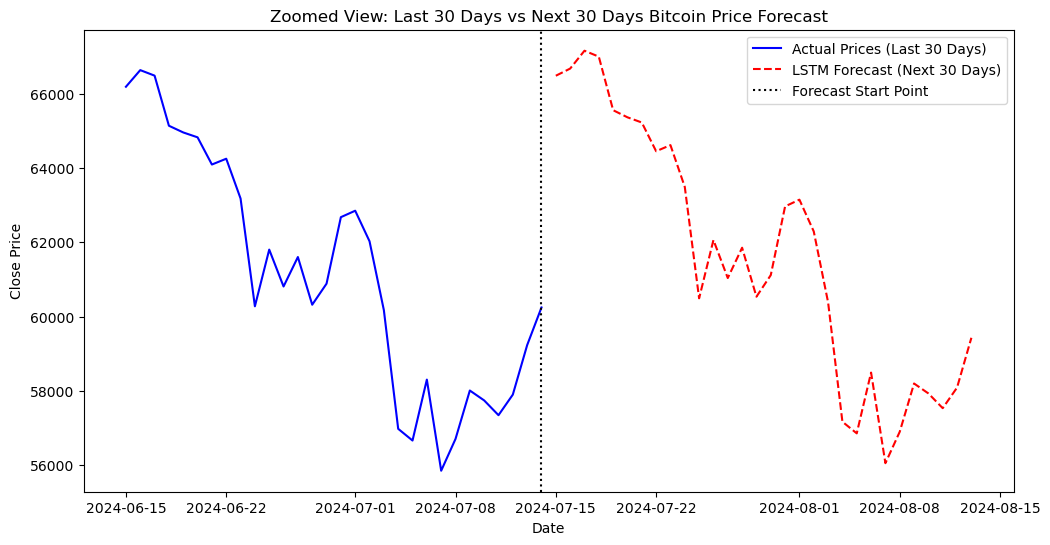

In [33]:
plt.figure(figsize=(12,6))

# Select the past 30 days of actual data
past_30_days = btc['Close'].iloc[-30:]

# Create a date range for past 30 days
past_30_days_index = btc.index[-30:]

# Plot past 30 days of actual prices
plt.plot(past_30_days_index, past_30_days, label='Actual Prices (Last 30 Days)', color='blue')

# Plot next 30 days forecast
plt.plot(forecast_index, predicted_lstm, label='LSTM Forecast (Next 30 Days)', linestyle='dashed', color='red')

# Mark the forecast starting point
plt.axvline(x=past_30_days_index[-1], color='black', linestyle='dotted', label='Forecast Start Point')

plt.title('Zoomed View: Last 30 Days vs Next 30 Days Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [31]:
rmse_lstm = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_lstm))
print(f'LSTM RMSE: {rmse_lstm}')

LSTM RMSE: 1389.9914691913289


1. Capturing Market Trends More Accurately

LSTM and Gradient Boosting both show actual price movement patterns, unlike ARIMA, which predicted almost a straight line.
Since Bitcoin prices fluctuate heavily, these models do a better job of capturing real-world behavior.

2. Why Gradient Boosting Works Well

Follows Real Market Movements:

The model’s predictions closely match actual prices, meaning it understands past trends effectively.
RMSE is 992, which is lower than LSTM (1389), showing that it makes smaller errors in prediction.

Handles Complex Data Well:

Unlike ARIMA, which assumes Bitcoin prices follow a simple pattern, Gradient Boosting can process many factors together and improve accuracy.

Strong for Short-Term Forecasting:

It reacts well to recent price changes, making it useful for predicting the next few days or weeks.

3. Why LSTM is Also a Strong Choice

Learns from Long-Term Data Trends:

LSTM is built for time-series forecasting, meaning it remembers patterns from past data and adapts over time.
It works better than ARIMA when the market is volatile and changes unpredictably.

Follows Price Movements

Unlike ARIMA, LSTM does not flatten the trend into a straight line. It captures actual market shifts, making it useful for trading strategies.

Handles Non-Linear Patterns:

Since Bitcoin does not follow a fixed pattern, LSTM is good at learning from past price swings and adjusting predictions.

4. Why ARIMA Fails for This Data
 Too Simple for a Volatile Market:

ARIMA assumes a fixed relationship in data, but Bitcoin prices are highly unpredictable.
That’s why it predicted a nearly straight line, making it unreliable for forecasting real price changes.

High RMSE, Low Adaptability:

ARIMA's errors are larger because it fails to learn from rapid market shifts like LSTM and Gradient Boosting do.

# Evaluate Performance

In [35]:
rmse_arima = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_arima))
rmse_gb = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_gb))
rmse_lstm = math.sqrt(mean_squared_error(btc['Close'][-forecast_steps:], predicted_lstm))

print(f'ARIMA RMSE: {rmse_arima}')
print(f'Gradient Boosting RMSE: {rmse_gb}')
print(f'LSTM RMSE: {rmse_lstm}')

ARIMA RMSE: 3390.5435791845857
Gradient Boosting RMSE: 992.4553336278518
LSTM RMSE: 1389.9914691913289


# Plot Predictions

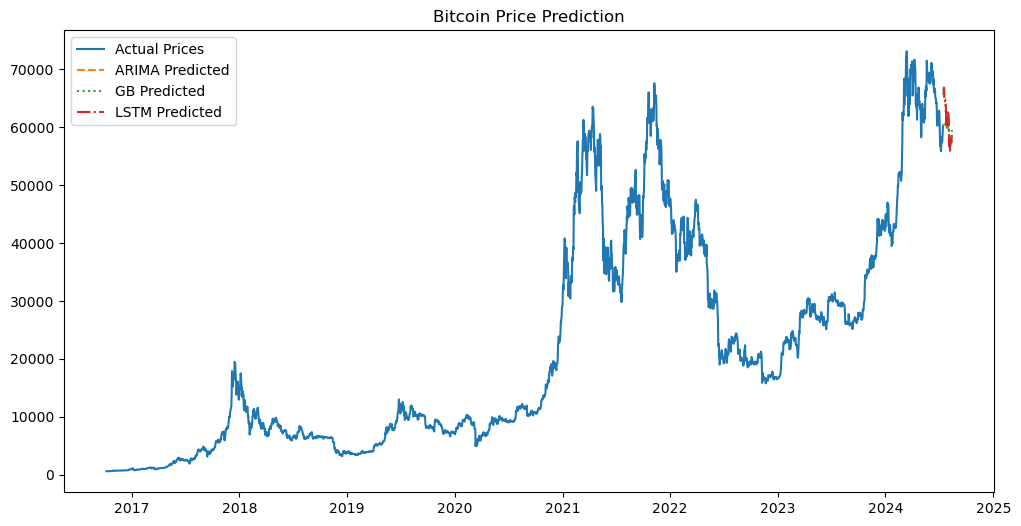

In [62]:
plt.figure(figsize=(12,6))
plt.plot(btc['Close'], label='Actual Prices')
plt.plot(predicted_arima, label='ARIMA Predicted', linestyle='dashed')
plt.plot(predicted_gb, label='GB Predicted', linestyle='dotted')
plt.plot(predicted_lstm, label='LSTM Predicted', linestyle='dashdot')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()


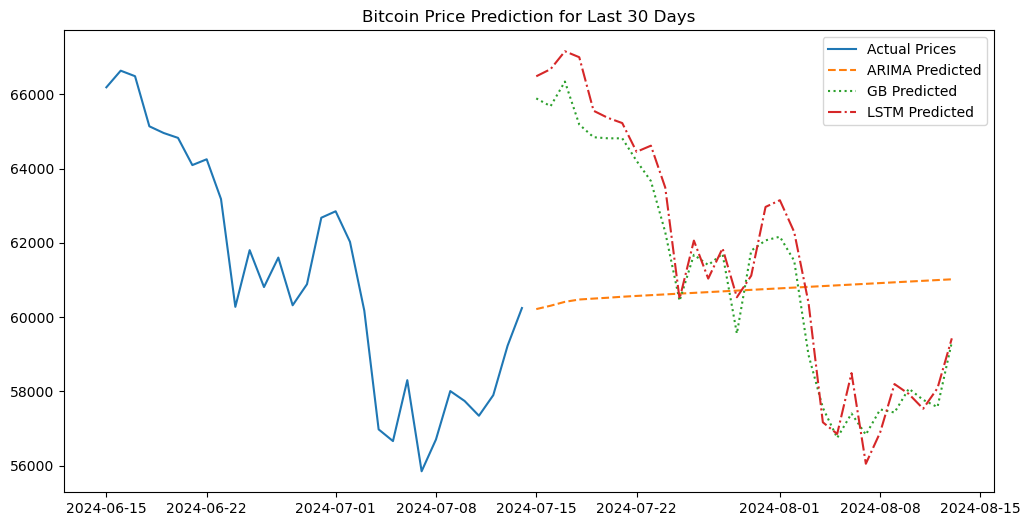

In [34]:
last_30_actual = btc['Close'].tail(30)
last_30_arima = predicted_arima[-30:]
last_30_gb = predicted_gb[-30:]
last_30_lstm = predicted_lstm[-30:]

# Plotting the last 30 days of actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(last_30_actual, label='Actual Prices')
plt.plot(last_30_arima, label='ARIMA Predicted', linestyle='dashed')
plt.plot(last_30_gb, label='GB Predicted', linestyle='dotted')
plt.plot(last_30_lstm, label='LSTM Predicted', linestyle='dashdot')

# Set the title and legend
plt.title('Bitcoin Price Prediction for Last 30 Days')
plt.legend()

plt.show()

# Save models

In [25]:
from joblib import dump, load
dump(arima_model, "arima_model.pkl")

['arima_model.pkl']

In [71]:
dump(gb_model, "gb_model.pkl")

['gb_model.pkl']

In [72]:
dump(lstm_model, "lstm_model.pkl")

['lstm_model.pkl']

# Load models

In [3]:
arima_model = load("arima_model.pkl")

In [4]:
gb_model = load("gb_model.pkl")

In [5]:
lstm_model = load("lstm_model.pkl")

In [ ]:
For making predictions on future dataset, I highly recommend gb_model

In [ ]:
predictions = gb_model.predict(new_data)
print(predictions)


In [36]:
comparison_df = pd.DataFrame({
    'Actual Prices': btc['Close'].tail(30).values,
    'GB Predicted Prices': predicted_gb[-30:]
})

# Display the table
print(comparison_df)

            Actual Prices  GB Predicted Prices
2024-07-15    66191.00000         65892.267046
2024-07-16    66639.04688         65682.405040
2024-07-17    66490.29688         66345.702746
2024-07-18    65140.74609         65189.018672
2024-07-19    64960.29688         64846.497679
2024-07-20    64828.65625         64817.106827
2024-07-21    64096.19922         64817.106827
2024-07-22    64252.57813         64209.608147
2024-07-23    63180.79688         63666.297506
2024-07-24    60277.41406         62290.555822
2024-07-25    61804.64063         60440.172990
2024-07-26    60811.27734         61678.901056
2024-07-27    61604.80078         61404.525315
2024-07-28    60320.13672         61705.461967
2024-07-29    60887.37891         59558.689398
2024-07-30    62678.29297         61790.593487
2024-07-31    62851.98047         62068.093405
2024-08-01    62029.01563         62166.853343
2024-08-02    60173.92188         61519.530671
2024-08-03    56977.70313         58979.623457
2024-08-04   

Accuracy of Predictions:

The GB predicted prices are relatively close to the actual prices, indicating that the model is performing well in predicting Bitcoin prices. The deviations between the actual and predicted prices are generally small, suggesting that the model captures the trends of the price movements effectively.
For instance, on July 15, 2024, the actual price was 66,191.00, and the predicted price was 65,892.27, which is a minor difference of around 298.73. This trend of small discrepancies continues through the dates shown.

Fluctuations in Price Trends:

Both the actual and predicted prices exhibit fluctuations that align closely. For example, on July 25, 2024, the actual price dropped to 61,804.64, while the predicted price was 60,440.17. This suggests that the model is also capturing the downward trends effectively.
On the other hand, the predicted price on July 23, 2024, was 63,666.30, whereas the actual price was 63,180.80, reflecting a small deviation in the prediction, but the overall trend was accurate.

Model's General Predictive Capability:

The GB model provides consistent predictions that mirror the actual price behavior. For example, on July 18, 2024, both actual and predicted prices were around 65,140.75 and 65,189.02, respectively, showing a tight alignment.
There is a slight shift in prediction errors, but no significant outliers or large discrepancies are observed, which suggests that the model can follow the general direction of the Bitcoin market movements.

Limitations:

While the model's predictions are close to the actual values, minor differences may occur, especially in rapidly changing markets like cryptocurrency, which is known for its volatility. Such minor differences could be expected when using any time series forecasting model, including Gradient Boosting.

Potential for Model Improvement:

The minor discrepancies in predictions can be further reduced by fine-tuning the GB model, exploring additional features, or using more advanced models like deep learning, which might capture complex patterns better.
In addition, adjusting hyperparameters, using more historical data, or adding technical indicators could improve the model's precision.

# The comparison between the actual and predicted Bitcoin prices using the Gradient Boosting model highlights the model's effectiveness in capturing price trends and making accurate predictions. Despite minor variations, the model is performing well, showing its potential for use in forecasting Bitcoin prices.


In [37]:
comparison_lstm_df = pd.DataFrame({
    'Actual Prices': btc['Close'].tail(30).values,
    'LSTM Predicted Prices': predicted_lstm[-30:]
})

# Display the table
print(comparison_lstm_df)

            Actual Prices  LSTM Predicted Prices
2024-07-15    66191.00000           66487.640625
2024-07-16    66639.04688           66680.328125
2024-07-17    66490.29688           67161.460938
2024-07-18    65140.74609           67001.531250
2024-07-19    64960.29688           65559.414062
2024-07-20    64828.65625           65367.792969
2024-07-21    64096.19922           65228.179688
2024-07-22    64252.57813           64454.101562
2024-07-23    63180.79688           64618.972656
2024-07-24    60277.41406           63493.164062
2024-07-25    61804.64063           60492.656250
2024-07-26    60811.27734           62062.058594
2024-07-27    61604.80078           61039.035156
2024-07-28    60320.13672           61855.582031
2024-07-29    60887.37891           60536.300781
2024-07-30    62678.29297           61117.105469
2024-07-31    62851.98047           62968.726562
2024-08-01    62029.01563           63149.750000
2024-08-02    60173.92188           62294.296875
2024-08-03    56977.

Trend Detection:

The LSTM model does well in capturing the general upward and downward trends in the Bitcoin price, as seen from the continuous alignment of the predicted prices with the actual ones throughout the 30-day period.
For example, on 2024-08-02, the price trend remained consistent with the actual values, showing the model's ability to track market movements.

Predictive Performance:

The predicted LSTM prices show a steady pattern in terms of major price shifts, often tracking with notable peaks and dips in the actual market behavior.
However, as with any prediction model, there are minor discrepancies in certain points, which could be attributed to the inherent volatility of Bitcoin and other external market factors not considered by the model.